In [2]:
#importation des bibiotheque necessaire
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
np.set_printoptions(precision=2, linewidth=80)
from nltk import FreqDist
# Gensim
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
#from bs4 import BeautifulSoup
import unicodedata

from spacy.lang.fr.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import fr_core_news_md #import spacy french stemmer

import pyLDAvis #Nous utilisons pyLDAvis pour créer des visualisations interactives de modèles de sujet.
import pyLDAvis.sklearn
from sklearn.decomposition import NMF,LatentDirichletAllocation
pyLDAvis.enable_notebook()

# Text Pre-Processing et Normalisation :
Avant de plonger dans le processus d'ingénierie et de modélisation des fonctionnalités, l'une des étapes clés
consiste à nettoyer, prétraiter et normaliser le texte pour amener les composants de texte tels que les phrases et les
mots dans un format standard. Cela permet la normalisation dans un corpus de documents, ce qui permet de
créer des fonctionnalités significatives et de réduire le bruit qui peut être introduit en raison de nombreux
facteurs tels que les symboles non pertinents, les caractères spéciaux, les balises XML et HTML

In [3]:
#output French accents correctly
def convert_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')

In [4]:
#convertisse les documents en minuscule
def lower_text(corpus):
    LowerCorpus=[]
    for doc in corpus:
        lowerDoc=str(doc).lower() #convertissent le texte en minuscules
        lowerDoc=convert_accents(lowerDoc).decode("utf-8") #supprimes les accents
        LowerCorpus.append(lowerDoc)
    return LowerCorpus


In [5]:
#supprimes caracteres speciaux
def remove_characters(corpus,keep_apostrophes=True):
    filtered_corpus=[]
    for doc in corpus:
        doc = doc.strip()
        if keep_apostrophes:
            doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls
            PATTERN = r'[?|$|&|*|%|@|(|)|~|\d]'
            filtered_doc = re.sub(PATTERN, r'', doc)
            filtered_corpus.append(filtered_doc)
        else:
            PATTERN = r'[^a-zA-Z ]'
            #supprimes les urls
            doc =re.sub('(https|http)\S*\s?', '',doc) #supprimes les urls
            filtered_doc = re.sub(PATTERN, r'', doc)
        
            filtered_corpus.append(filtered_doc)
    return filtered_corpus

In [6]:
#Tokenization
def tokenize_text(corpus):
    tokensCorpus=[]
    for doc in corpus:
        doc_tokens = word_tokenize(doc)
        tokensCorpus.append(doc_tokens)
    return tokensCorpus



In [7]:
#recuperer les mots qui apparaissent dans plusieurs documents
def get_mostCommonWords(corpus,max_freq=100):
    vocabulaire=dict() #dictionnaire qui va contenir le nombre d'occurence des mots dans les documents
    for doc in corpus:
        for word in set(doc.split()): #recupere les mots unique de chaque documents
            if word in vocabulaire:
                vocabulaire[word]+=1
            else:
                vocabulaire[word]=1
    
    #recupere les dont le nombre d'occurences dans les documents > max_freq
    mostCommonsWord=[word for word,value in vocabulaire.items() if value>max_freq ]
        
    return mostCommonsWord


In [8]:

# removing stopwords
def remove_stopwords(corpus,mostCommonsWord):
    filtered_corpus=[]
    for tokens in corpus:
        others_sw=["maroc","morocco","marocain","marocaine","marocains","marocaines","maghreb","météorologique","journée",
                   "méteo","retweet","newspic","twitter","com","pic","newspic","illustration"]
        
        #french_sw = stopwords.words('french') 
        french_sw=list(STOP_WORDS) #get french stopwords
        french_sw.extend(others_sw)
        french_sw.extend(mostCommonsWord)
        
        filtered_tokens = [token for token in tokens.split() if token not in french_sw and len(token)>2]
        filtred_text=' '.join(filtered_tokens) #reforme le text du documents separé par espace
        filtered_corpus.append(filtred_text)
    return filtered_corpus

In [9]:
#lemmatisation
def lemm_tokens(corpus):
    
    nlp = fr_core_news_md.load() #initialisation du model "fr_core_news_md" de spacy
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    corpus_lemms=[]
    
    idx_doc=[] #liste qui va stocker les indices documents qui seront dans le corpus
    for idx,document in enumerate(corpus):
        doc = nlp(document)
        lemms=[token.lemma_ for token in doc if token.pos_ in allowed_postags] #recupere les lemms des tokens
        
        if len(lemms)>5: #supprime les document qui ne contient pas plus de 2 mots
            text=' '.join(lemms) #reforme le text du documents separé par espace
            corpus_lemms.append(text)
            idx_doc.append(idx) #ajoute l'indice du documents
            
    return corpus_lemms,idx_doc

In [10]:
#fonction qui supprimes les documents vides ou tres courte
def remove_shortDocument(corpus,min_length=3):
    filtred_corpus=[]
    idx_doc=[]
    for idx,doc in enumerate(corpus):
        
        if len(doc.split())>min_length:
            filtred_corpus.append(doc)
            idx_doc.append(idx)
        
    
    return filtred_corpus,idx_doc
            
            

In [11]:
def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=2, threshold=10) # higher threshold fewer phrases
    # Un moyen plus rapide d'obtenir une phrase matraquée comme un trigramme / bigramme
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    corpus_bigram=[" ".join(bigram_mod[doc]) for doc in texts]
    return corpus_bigram

In [12]:
def preprocessing(corpus):
    
    corpus=lower_text(corpus)
    corpus=remove_characters(corpus)
    corpus=tokenize_text(corpus)
    #corpus=remove_mostCommonWords(corpus,max_freq=20)
    corpus=remove_stopwords(corpus)
    corpus,idx_docs=lemm_tokens(corpus)
    
    
    return corpus,idx_docs


In [13]:
#dataset=pd.read_csv("dataset.csv",sep=",",lineterminator='\n',encoding="utf8")

In [14]:
dataset=pd.read_csv("clean_corpus.csv",sep=",")

In [15]:
dataset

,text,date
0,adepte hammam traditionnel quartier sidi youss...,2019-11-26
1,fidèle réputation trublion imprévisible dévoil...,2019-11-22
2,retrouver mourir vendredi dernier chambre hôte...,2019-11-04
3,lancé nouveau série reno modèle reno reno smar...,2019-11-24
4,nouveau centre commercial apprête voir jour me...,2019-11-20
...,...,...
54920,officiel député princes_princesse conseiller f...,2019-11-12
54921,post- brexit choisir centre alternatif fabrica...,2019-11-12
54922,proposer démarche humain respectueux souverain...,2019-11-12
54923,solidariter prêter attention souffrance sort f...,2019-11-12


In [38]:
corpus = dataset.text.values.tolist()
print("Taille du corpus = "+str(len(corpus))+" Documents")

Taille du corpus = 54925 Documents


In [39]:
#corpus,idx_docs=preprocessing(corpus)

In [40]:
corpus=lower_text(corpus)

In [41]:
most_commonWords=get_mostCommonWords(corpus,500) #recupere les mots qui apparaisent dans plusieurs document
print("Nombre de mots tres frequents = "+str(len(most_commonWords))+" Mots")

Nombre de mots tres frequents = 168 Mots


In [42]:
corpus=remove_stopwords(corpus,most_commonWords)#supprimes les mots les plus frequents,les stop words et qlq mots inutiles
corpus,idx_doc=remove_shortDocument(corpus,min_length=5) #supprimes les documents vides
print("Nouvelle Taille du corpus = "+str(len(corpus))+" Documents")

Nouvelle Taille du corpus = 34729 Documents


# TF-IDF

In [43]:
# build TFIDF features on train reviews with a specifique vocabulary
corpus_lemmatized=tokenize_text(corpus) 
id2word = corpora.Dictionary(corpus_lemmatized)
vocabulaire=id2word.token2id #get vocabulary dict where keys are terms and values are indices in the feature matrix

tfidf = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0,sublinear_tf=True,lowercase=True,ngram_range=(1,2),vocabulary=vocabulaire)
tfidf_train_features = tfidf.fit_transform(corpus)

# Construiction du modèle de sujet :
Le modèle est construit avec **10 sujets** initiaux où chaque sujet est une combinaison de mots-clés et chaque mot-clé contribue à un certain poids au sujet.

In [44]:
# build topic model on positive sentiment review features
#total_topics = 10 #nombre de topics
#pos_nmf = LatentDirichletAllocation(n_components=total_topics, random_state=100,learning_method='online',doc_topic_prior=0.01/t,topic_word_prior=0.01/t)
#pos_nmf.fit(tfidf_train_features) 

In [45]:
total_topics = 10 #nombre de topics
pos_nmf=NMF(n_components=total_topics,random_state=42,l1_ratio=0.2,max_iter=200)
pos_nmf.fit(tfidf_train_features) 

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.2, max_iter=200,
  n_components=10, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

# Affichage des sujets 

In [46]:
# extractions des features et des poids
pos_feature_names = tfidf.get_feature_names()
pos_weights = pos_nmf.components_

In [47]:
# extracts topics with their terms and weights
# format is Topic N: [(term1, weight1), ..., (termn, weightn)]        
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    
    #trie les indices des mots de chaque topics selon la poids du mots dans le topics
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    
    #trie les poids des mots de chaques topics,en recuperant les poids des indices deja triée
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights,sorted_indices)])
    
    #recupres les mots selon leurs indices deja triée
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    
    #concatene chaque mots et sa poids sous formes de tuple (mot,poids)
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]     
    
    return topics


# prints components of all the topics 
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,weight_threshold=0.0001,display_weights=False,num_terms=None):
    
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt)) for term, wt in topic] #recupere les mots et les poids du topic
        
        #seuillage des mots selon le seuil de poids definie
        topic = [(word, round(wt,2)) for word, wt in topic if abs(wt) >= weight_threshold]
        
        #affiches les "num_terms" de chaque topics
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw
        print()


In [48]:
# extract and display topics and their components
pos_topics = get_topics_terms_weights(pos_weights, pos_feature_names)
print_topics_udf(topics=pos_topics,total_topics=total_topics,num_terms=15,display_weights=True)

Topic #1 with weights
[('cafe', 2.73), ('nutritionnel', 1.63), ('minceur', 1.63), ('differer', 1.63), ('noir', 1.56), ('racisme', 0.01), ('cremer', 0.01), ('liste', 0.01), ('sortir', 0.0), ('blanc', 0.0), ('policier', 0.0), ('paradis', 0.0), ('savon', 0.0), ('drapeau', 0.0), ('decoration', 0.0)]

Topic #2 with weights
[('kafaler', 1.73), ('parental', 1.73), ('recueil', 1.73), ('assimiler', 1.73), ('tutelle', 1.72), ('legal', 1.7), ('age', 0.0), ('ministere', 0.0), ('contrebande', 0.0), ('mineur', 0.0), ('demander', 0.0), ('delai', 0.0), ('auj', 0.0), ('traverser', 0.0), ('enseignant', 0.0)]

Topic #3 with weights
[('honnete', 1.51), ('patriotique', 1.51), ('repondre', 1.49), ('citoyen', 1.34), ('humainement', 1.18), ('mohamed', 0.85), ('humiliation', 0.51), ('exclusion', 0.51), ('enormement', 0.51), ('souffrir', 0.5), ('socialement', 0.48), ('detresse', 0.46), ('appels', 0.45), ('prince', 0.45), ('recherche', 0.43)]

Topic #4 with weights
[('mali', 1.61), ('togo', 1.53), ('cameroun', 1

# Calcul de la cohérence du modèle :
La cohérence des sujets constituent une mesure pratique pour juger de la qualité d'un modèle de sujet,ic on utilise **La Coherence UMass** qu'on a implementé nous meme.

In [49]:
def getTopicTerms(pos_topics):
    """
    Fonction qui retourne l'ensemble des mots qui compose chaque topics
    ----Input----
    pos_topics: ensemble des topics qui contients les mots et leurs poids
    ---output---
    topic_terms : ensemble des mots des topics
    
    """
    topic_terms=[]
    for topic in pos_topics:
        #topic=topic[:max_term] #recupere les "max_term" premiere mots et leurs poids
        terms=[]
        for doc in topic:
            terms.append(doc[0]) #recupere justes les mots sans les poids
        
        topic_terms.append(terms) #ajoute l'ensemble des mots
    
    return topic_terms

In [50]:
topic_terms=getTopicTerms(pos_topics) #recupere les mot des de chaque topics

topic_terms=[topics[:20] for topics in topic_terms] #recupere les termes avec les plus grandes poids
# Term Document Frequency
common_corpus = [id2word.doc2bow(text) for text in corpus_lemmatized]

cm = CoherenceModel(topics=topic_terms,corpus=common_corpus, dictionary=id2word, coherence='u_mass')
coherence = cm.get_coherence()
print("Coherence = ", coherence)

Coherence =  -10.387115563319478


# Trouver le nombre de sujets optimal :
Pour trouver le nombre  de sujets optimal est de construire de nombreux modèles avec différentes valeurs de nombre de sujets **k** et de choisir celui qui donne la valeur de **cohérence UMass** la plus élevée.

In [51]:
def compute_coherence_values(tfidf_train_features,feature_names,corpus,data_lemmatized,id2word,max_term=20,limit=50, start=5, step=5):
    """
    Calcul la coherence UMass pour different nombre de topic
    
    Parameters:
    ----------
    tfidf_train_features : features tf-idf qu'on va utiliser pour entrainer chaque model
    feature_names : ensemble des mots contenue dans la matrice tf-idf
    corpus: corpus de base qui contients les documents sous forme de texte
    max_term: nombre maximal de mots qu'on va prendre pour calculé la coherence de chaque topic
    data_lemmatized: corpus sous forme de tokens
    id2word:vocabulaire du corpus au format de gensim
    max_term:le nombre de termes qu'on va prendre dans chaque topic pour calculer la Coherence
    limit : Nombre maximal de topics qu'on va tester

    Returns:
    -------
    best_model : le model qui contient le plus grande coherence
    coherence_values : Valeurs des Cohérences correspondant au modèle avec le nombre respectif de sujets
    """
    
    
    model_list = [] #listes qui va contenir les modeles tester
    coherence_values = [] #liste qui contenir les coherences de chaque models
    # Term Document Frequency
    
    common_corpus = [id2word.doc2bow(text) for text in data_lemmatized] #recupere la matrice bog of word du corpus sous le format de gensim

    
    #print(coherence)
    for num_topics in range(start, limit, step):
        
        model=NMF(n_components=num_topics,random_state=42) #model MNF
        model.fit(tfidf_train_features)
        weights = model.components_ #recupere les poids
        
        model_list.append(model) #ajoute le model la liste des models utilisé
        
        
        topics=get_topics_terms_weights(weights,feature_names)
        
        topic_terms=getTopicTerms(topics)#recupere les mot des de chaque topics
        
        topic_terms=[topics[:max_term] for topics in topic_terms] #recupere les  "max_term" termes avec les plus grandes poids
        
        #calcule du Coherence UMass
        cm = CoherenceModel(topics=topic_terms,corpus=common_corpus, dictionary=id2word, coherence='u_mass')
        coherence = cm.get_coherence()
        coherence_values.append(coherence)
    
    idx_max=np.array(coherence_values).argmax() #recupere l'indice du model qui possede le plus grands coherence
    best_model=model_list[idx_max] #recupere le meilleur models
    

    return best_model,coherence_values

In [52]:
best_model,coherence_values=compute_coherence_values(tfidf_train_features,pos_feature_names,
                                                     corpus,corpus_lemmatized,id2word,max_term=20,limit=50)

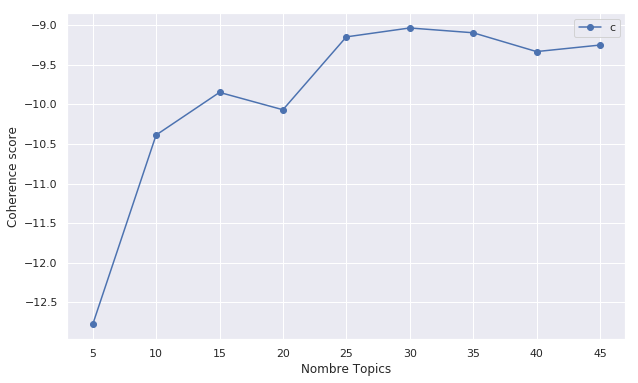

In [53]:
# Show graph
import seaborn as sns
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
limit=50; start=5; step=5;
x = range(start, limit, step)
plt.plot(x,np.array(coherence_values),marker="o")
plt.xlabel("Nombre Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [54]:
total_topics=best_model.n_components #recupere le nombre de topics du meilleurs modeles
weights = best_model.components_ #recuperes les poids du meilleurs modeles
# extract features and component weights
feature_names = tfidf.get_feature_names()

print("Le nombre de topic optimal est : ",total_topics)
print("*"*100)
topics = get_topics_terms_weights(weights,feature_names)
print_topics_udf(topics,total_topics,num_terms=15,display_weights=False)

Le nombre de topic optimal est :  30
****************************************************************************************************
Topic #1 without weights
['cafe', 'nutritionnel', 'minceur', 'differer', 'noir', 'racisme', 'cremer', 'liste', 'sortir', 'blanc', 'policier', 'paradis', 'savon', 'drapeau', 'americain']

Topic #2 without weights
['kafaler', 'parental', 'recueil', 'assimiler', 'tutelle', 'legal', 'age', 'ministere', 'contrebande', 'demander', 'mineur', 'delai', 'traverser', 'auj', 'enseignant']

Topic #3 without weights
['repondre', 'humainement', 'patriotique', 'honnete', 'citoyen', 'socialement', 'appels', 'recherche', 'prince', 'detresse', 'degre', 'mohamed', 'majester', 'appauvrissement', 'marginalisation']

Topic #4 without weights
['mali', 'togo', 'cameroun', 'cotedivoire', 'gabon', 'rwander', 'cotedivoir', 'faso', 'comore', 'rdc', 'benin', 'mourir', 'malagasy', 'guinee', 'dollar']

Topic #5 without weights
['accord', 'partenariat', 'investissement', 'signer', '

In [55]:
# Visualize the topics
pyLDAvis.sklearn.prepare(best_model,tfidf_train_features, tfidf, R=15)

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
17     20.654476        1       1 -0.154294  0.121894
4       9.729181        1       2 -0.146518  0.092008
23      8.560891        1       3 -0.136578  0.081177
16      8.070561        1       4 -0.087932  0.026787
29      5.843868        1       5 -0.164585  0.093320
11      4.137715        1       6 -0.054074 -0.063964
24      3.913548        1       7 -0.110199  0.015915
12      3.538991        1       8 -0.067982 -0.002983
25      3.303572        1       9 -0.070218 -0.099270
19      2.405577        1      10 -0.068110 -0.025788
27      2.372745        1      11 -0.104018  0.053593
22      2.284870        1      12 -0.044398 -0.041471
9       2.249900        1      13 -0.081081  0.029946
21      2.247873        1      14 -0.077830  0.067790
6       2.168820        1      15 -0.037614 -0.094057
14      2.112917        1      16  0.012874  0.096366
7       2.089814        1      17  0.015864  0.036754
3       1.819464        1      18 -0.055228 -0.049879
13      1.749332        1      19 -0.071464 -0.059075
10      1.608772        1      20  0.089622  0.110112
15      1.237168        1      21  0.114065  0.074883
28      1.144283        1      22  0.159352  0.054797
26      1.017974        1      23  0.138964  0.054840
0       0.963475        1      24  0.097313 -0.237842
1       0.874536        1      25  0.138703 -0.283577
18      0.850576        1      26  0.264969  0.134198
2       0.840980        1      27  0.262352  0.113118
5       0.837841        1      28  0.211069  0.078291
20      0.721864        1      29  0.023021 -0.157126
8       0.648415        1      30  0.003954 -0.220755, topic_info=      Category        Freq        Term       Total  loglift  logprob
1123   Default  267.000000        cafe  267.000000  15.0000  15.0000
557    Default  360.000000    tourisme  360.000000  14.0000  14.0000
1007   Default  192.000000      proces  192.000000  13.0000  13.0000
1379   Default  275.000000  avortement  275.000000  12.0000  12.0000
4884   Default  229.000000        pler  229.000000  11.0000  11.0000
...        ...         ...         ...         ...      ...      ...
985    Topic30    2.431430      double   50.435059   2.0062  -5.5779
473    Topic30    2.853396  journalist  100.719814   1.4746  -5.4178
1159   Topic30    2.437434   ouverture   73.083516   1.6377  -5.5754
11373  Topic30    1.761519     cliquer   25.886838   2.3508  -5.9002
187    Topic30    2.055267    presumer  136.115128   0.8453  -5.7459

[965 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
13583      7  0.962948        abderazzak
14696      6  0.898653          abortion
1254       2  0.162470             acces
1254       4  0.011605             acces
1254       5  0.058025             acces
...      ...       ...               ...
28611     27  1.206454        xwiuftfqpx
9395      27  1.206454         xwvvjajug
23618     14  1.308950           yckbvsa
21204      7  1.662589  yvessaintlaurent
10903     27  1.206454          zfwavuko

[1957 rows x 3 columns], R=15, lambda_step=0.01, plot_opts={'ylab': 'PC2', 'xlab': 'PC1'}, topic_order=[18, 5, 24, 17, 30, 12, 25, 13, 26, 20, 28, 23, 10, 22, 7, 15, 8, 4, 14, 11, 16, 29, 27, 1, 2, 19, 3, 6, 21, 9])

# Trouver le sujet dominant dans chaque document :
Pour trouver cela,il suffit de trouver le numéro de topic qui a le pourcentage de contribution le plus élevé dans ce document

In [56]:
def topic_dominant(model,tdidf_features,corpus,topics):
    
    #document topic distribution :la probabilité des topics pour chaque document
    doc_topic_dist = model.transform(tdidf_features) 
    
    topic_num=[] #liste qui contenir le numero du topic dominant dans chaque documents
    probs_topics=[] #liste qui va contenir les probabilités du topic dominant dans chaque documents
    topic_keywords=[] #liste qui contenir les 5 termes les plus representative du sujet
    text_doc=[] #liste qui va contenir le texte de chaque documents
    
    topic_terms=getTopicTerms(topics) #recupere les mot de chaque topics
    
    num_doc=[]
    
    for i,doc in enumerate(doc_topic_dist):
        text_doc.append(corpus[i]) #recupere le texte du documents
        num_doc.append(i+1) #recupere le numero du documents
        
        idx_max=doc.argmax() #recupere l'indice du topic qui a de la probabilité maximal
        topic_num.append(idx_max) 
        probs_topics.append(round(doc.max(),4)) #recupere la probabilité maximal arrondis
        
        kw=",".join(topic_terms[idx_max][:5]) #recupere les mots clé du topic
        topic_keywords.append(kw)
        
    
    sent_topics_df = pd.DataFrame([num_doc,topic_num,probs_topics,topic_keywords,text_doc]).T
    sent_topics_df.columns=["Num Document","Topic Dominant","Contrib Topic","Key Word","Text"]
    
    return sent_topics_df

In [57]:
sent_topics_df=topic_dominant(best_model,tfidf_train_features,corpus,topics)
sent_topics_df.sample(20)

,Num Document,Topic Dominant,Contrib Topic,Key Word,Text
15769,15770,29,0.1315,"tourisme,vacance,information,plan,carte",vacance etude vacance decrypter cabinet comman...
24111,24112,23,0.0564,"football,final,joueur,caf,champion",remise trophee meilleur joueur ajax_d_amsterda...
15346,15347,17,0.0034,"ambassadeur,chef,recevoir,etudiant,etranger",progresse rythme pragmatisme realisme perennit...
9572,9573,4,0.0069,"accord,partenariat,investissement,signer,energie",mobile money enorme levier acceleration inclus...
15363,15364,28,0.0943,"superieur,poste,nomination,approbation,raisonn...",demander proceder rentree remaniement gouverne...
29228,29229,23,0.0244,"football,final,joueur,caf,champion",sorte tache lourd competition maison rebondiss...
9749,9750,14,0.0335,"question,fois,discours,adresser,retenir",fois dictatur ingerer interne communaute commu...
2558,2559,7,0.0328,"demande,envoyer,continue,obtenir,maniere",lendemain demission horst envoyer personnel se...
19718,19719,4,0.0143,"accord,partenariat,investissement,signer,energie",jamais partenariat demeure clef vout socio-eco...
6551,6552,17,0.0023,"ambassadeur,chef,recevoir,etudiant,etranger",macron marionnette botte lobby macron lobby


# Trouvez le document le plus représentatif pour chaque sujet :
Parfois, seuls les mots-clés du sujet peuvent ne pas être suffisants pour donner un sens au sujet d'un sujet. Donc, pour vous aider à comprendre le sujet, vous pouvez trouver les documents auxquels un sujet donné a le plus contribué et en déduire le sujet en lisant ce document

In [58]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd =sent_topics_df.groupby('Topic Dominant')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted= pd.concat([sent_topics_sorted, grp.sort_values(['Contrib Topic'], ascending=[0]).head(1)], 
                                    axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted=sent_topics_sorted.drop(["Num Document"],axis=1)
# Show
sent_topics_sorted.head(20)

,Topic Dominant,Contrib Topic,Key Word,Text
0,0,0.2365,"cafe,nutritionnel,minceur,differer,noir",cafe minceur differer cafe noir nutritionnel
1,1,0.2369,"kafaler,parental,recueil,assimiler,tutelle",recueil legal kafaler assimiler tutelle parental
2,2,0.172,"repondre,humainement,patriotique,honnete,citoyen",patriotique honnete humainement repondre patri...
3,3,0.2392,"mali,togo,cameroun,cotedivoire,gabon",ex-premier mali cotedivoire togo gabon camerou...
4,4,0.0775,"accord,partenariat,investissement,signer,energie",strategique renforcer adoption europeen accord...
5,5,0.1705,"degre,menacer,expulsion,itinerance,injustement",roi_mohammedvi secourir pler degre menacer iti...
6,6,0.214,"datesconcour,date,rappel,limite,admission",rappel date admission septembre datesconcour o...
7,7,0.2934,"demande,envoyer,continue,obtenir,maniere",demande envoyer maniere continue obtenir brass...
8,8,0.273,"proces,hajarraissouni,revolte,sordide,sursis",sordide proces hajarraissouni proces revolte s...
9,9,0.293,"amour,coupl,citation,proverbe,dicton",personn instagram docteur_solution citation pr...


# Trouver les sujets les plus dominants dans le corpus :
Pour cela il suffit de trouver la frequence d'apparition de chaque theme dans le corpus

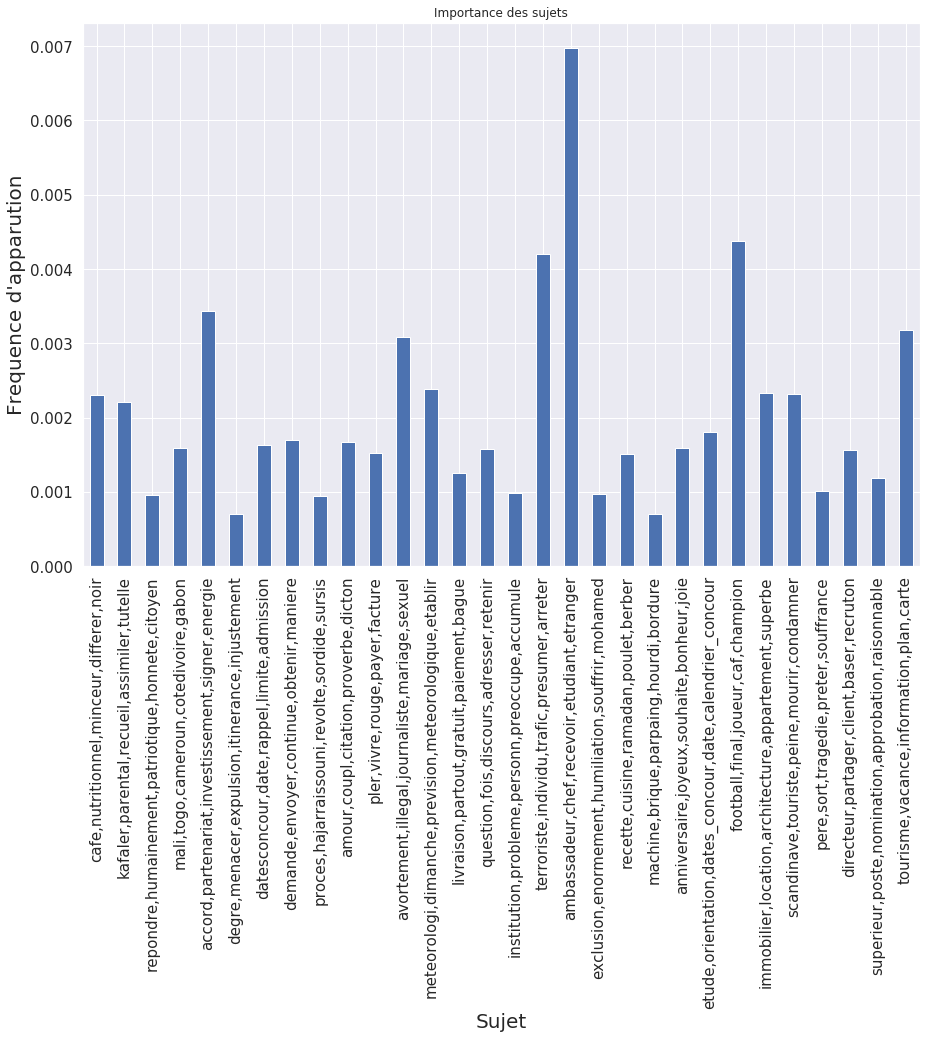

In [81]:
story_topics.drop(["doc_num"],axis=1).mean(axis=0).plot(kind='bar', title ="Importance des sujets",
                                                        figsize=(15,10), fontsize=15)
plt.xlabel("Sujet", fontsize=20)
plt.ylabel("Frequence d'apparution", fontsize=20)
plt.show()

# Evolution des Sujets dans le temps :
A partir du graphique,precedent on prends les 5 sujets les plus dominants et on visualise leurs evolutions au cours du temps

In [82]:
#recupere les dates sous formes de datime,on cherche juste les documents dont les indices sont "idx_doc"
dates=pd.to_datetime(dataset.iloc[idx_doc]["date"].values)

#dates=pd.to_datetime(dataset["date"].values)#recupere les dates sous formes de datime

#document topic distribution :la probabilité des topics pour chaque document
doc_topic_dist = best_model.transform(tfidf_train_features) 

labels=getTopicTerms(topics) #recupere les mots des topics
labels=[",".join(topic_term[:5]) for topic_term in labels] #recupere juste les 3 premieres mots

#formation 'un dataframe qui contient la date,le numero et le text de chaque documents
df=pd.DataFrame({"text":corpus,"date":dates,"doc_num":np.arange(len(corpus))})

stories=df.groupby("doc_num")["text","date"].min().reset_index() #trie les articles selon les dates

#formation d'un dataframe qui contient juste le numero de chaque document du corpus
story_topics=pd.DataFrame(dict(doc_num=np.arange(doc_topic_dist.shape[0])))


#recuperation des poids de chaque sujets dans chaque documents,puis on cree un une colonne dans le dataframe 
#qui va contenir l'ensemble de ces poids pour chaque sujets
for idx in range(len(labels)):
    story_topics[labels[idx]] = doc_topic_dist[:, idx]


#concatenations des dataframes par rapport au numero de documents
trends = stories.merge(story_topics, on='doc_num')

mass = lambda x: ((x) * 1.0).sum() / x.shape[0] #fonction qui calcule la moyenne 
window = 10
aggs = {labels[17]: mass,labels[4]:mass,labels[23]:mass,labels[16]:mass,labels[11]:mass}

#regroupe les poids par date,puis calcule la moyenne de chaque groupe,puis ouvre une fenetre glissant et enfin calcul la moyenne
data=trends.groupby(trends['date'].dt.date).agg(aggs).rolling(window).mean()


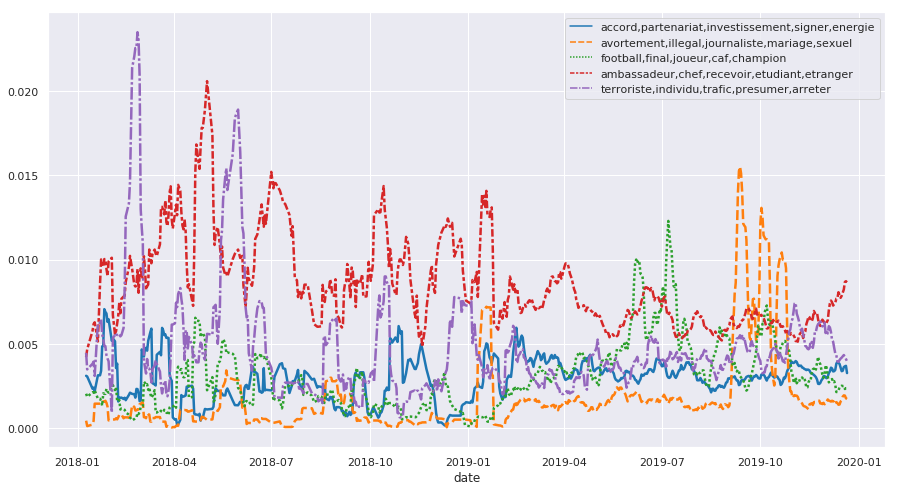

In [83]:
plt.figure(figsize=(15,8))
sns.lineplot(data=data, palette="tab10", linewidth=2.5)